In [74]:
from splinter import Browser
from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
import os
import pymongo
import pandas as pd
import re
import seaborn as sns
import time

In [ ]:
# use pymongo to store all info from LinkedIN
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
db = client.linkedin_db

In [2]:
# chrome_driver_path = os.path.abspath(r"C:\Users\haneu\Desktop\Data Analytics\6_mongo_webScrape\chromedriver.exe")
executable_path = {'executable_path': "chromedriver.exe"}
browser = Browser('chrome', **executable_path, headless=False)
url = "https://www.glassdoor.ca/index.htm"
browser.visit(url)

In [3]:
print("What job are you looking for?")
job = input()
job_type = browser.find_by_id("KeywordSearch")
job_type.fill(job)

print("Where do you want to find your job?")
job_location = input()
location = browser.find_by_id("LocationSearch")
location.fill(job_location)

# Clicking button
browser.find_by_id("HeroSearchButton").click()

What job are you looking for?
Data Scientist
Where do you want to find your job?
Singapore


In [4]:
# ------------ Scraping current page ------------
def scrape():
    # Getting html of the page then find all lists with class jl. 
    # jobs variable now contain all job listing's html tags in list form.
    html = browser.html
    soup = BeautifulSoup(html, "html.parser")
    jobs = soup.find_all("li", class_="jl")
    
    # Loop through each job listing
    for job in jobs:
        # Store all info into a appropriate storage.         
        position.append(job.find("div", class_="jobTitle").a.text)
        
        # name of company and location come in a form of ex: Tommy - Singapore   
        comp_loc = job.find("div", class_="empLoc").div.text
        comp, loc = comp_loc.split("–")
        # get rid of trailing white space then append to company list.
        company.append(comp.strip())
   
        location.append(loc.strip())
        browser.click_link_by_href(job.find("a", class_="jobLink")["href"])
        
        # ------------- Scrape Job descriptions within a page -----------
        # from current html since if you click job_posting it render new html
        html = browser.html
        soup = BeautifulSoup(html, "html.parser")
        job_desc.append(soup.find("div", class_="desc").text)
        # It is because if you are going too fast it skips some jobs desc.         
        time.sleep(3)

In [5]:
# ------------- loop through pages only up to 5th. ------------

html = browser.html
soup = BeautifulSoup(html, "html.parser")
result = soup.find("div", class_="pagingControls").ul
pages = result.find_all("li")

# creating storage for storing data retrieved from scrape() function
position = []
exp_level = []
company = []
employment_type = []
location = []
job_desc = []

# Loop through each list => each page
for page in pages:
    # scrape all job posting data in current page    
    scrape()
    
    # run if <a> exists since un-clickables do not have <a> skipping < and pg1     
    if page.a:
        # within <a> tag click except next button
        # "Next" is when you are finished with first 5 and want to goto next set
        # of page lists. 
        if not page.find("li", class_="Next"):
            
            # continue until you hit list with "Next" class, then stop.            
            try:
                browser.click_link_by_href(page.a['href'])

            except:
                print("This is the last page")
     

This is the last page


In [10]:
# checking duplicate scrape
# Total 30 jobs in each page.
print(len(job_desc))
print(len(set(job_desc)))

# get list of it and turn it back to a list. 
# job_desc = set(job_desc)
# job_desc = list(job_desc)

141
141


In [11]:
# ------------- Text classification to classify technical skill words --------------
# Some words are connected with / ex:"sql/database", so split them.
for job in job_desc:
    ", ".join(job.split('/'))
job_desc = [", ".join(job.split('/')) for job in job_desc]

# each item is a list of tokenized job_descriptions
tok = [nltk.word_tokenize(job.lower()) for job in job_desc]

from nltk.corpus import stopwords
stop = stopwords.words('english')
def stopword_deleter(tokenized_job_desc):
    """ ignore stop words, bullets, etc. And put it into one list """
    final_word_list = []
    for lists in tokenized_job_desc:
        for item in lists:
            if len(item)>2 and (item not in stop):
                # Some words have \\ at the end, remove them.           
                final_word_list.append(item.replace("\\",""))
    return final_word_list


# ------------ Lematize
cleaned_list = stopword_deleter(tok)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_list = [lemmatizer.lemmatize(word,pos="v") for word in cleaned_list]

In [44]:
# -------------Taking a look at POS tags -(NOT USED)
pos_tag = nltk.pos_tag(lemmatized_list)
pos_df = pd.DataFrame(pos_tag, columns=["Word", "POS"])
pos_sum = pos_df.groupby("POS").count()
pos_sum.sort_values(["Word"], ascending=False)

filtered_pos_tag = []
for tag in pos_tag:
    if tag[1] =="NN" or tag[1] == "NNS" or tag[1] =="NNP" or tag[1] == "NNPS":
        filtered_pos_tag.append(tag)

In [12]:
# Find 100 most frequent words
freq = nltk.FreqDist(lemmatized_list)
most_freq_words = freq.most_common(100)
most_freq_words

[('data', 1208),
 ('experience', 559),
 ('work', 408),
 ('learn', 392),
 ('business', 368),
 ('team', 339),
 ('model', 323),
 ('machine', 258),
 ('science', 246),
 ('use', 231),
 ('skills', 210),
 ('analytics', 194),
 ('build', 192),
 ('develop', 182),
 ('analysis', 178),
 ('engineer', 169),
 ('knowledge', 166),
 ('process', 146),
 ('statistical', 144),
 ('python', 139),
 ('techniques', 138),
 ('solutions', 137),
 ('strong', 137),
 ('project', 137),
 ('years', 136),
 ('computer', 136),
 ('apply', 134),
 ('problems', 133),
 ('understand', 128),
 ('tool', 128),
 ('research', 126),
 ('new', 123),
 ('algorithms', 119),
 ('insights', 119),
 ('deep', 116),
 ('role', 111),
 ('include', 110),
 ('etc', 109),
 ('product', 109),
 ('statistics', 109),
 ('program', 106),
 ('ability', 106),
 ('solve', 105),
 ('help', 104),
 ('drive', 103),
 ('technology', 102),
 ('support', 100),
 ('scientist', 99),
 ('design', 98),
 ('development', 94),
 ('technical', 91),
 ('job', 90),
 ('mine', 90),
 ('company', 

In [13]:
df = pd.DataFrame(most_freq_words, columns=("Words", "Count"))
df.head()

,Words,Count
0,data,1208
1,experience,559
2,work,408
3,learn,392
4,business,368


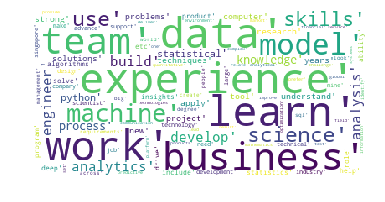

In [14]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(most_freq_words))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

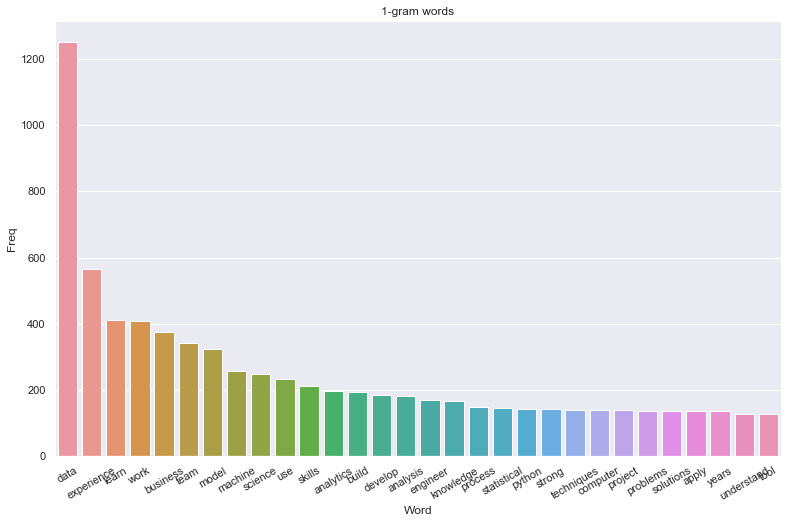

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(cleaned_corpus, n=None):
    vec = CountVectorizer().fit(cleaned_corpus)
    bag_of_words = vec.transform(cleaned_corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

top_words = get_top_n_words(lemmatized_list, n=30)
top_df = pd.DataFrame(top_words)

In [77]:
# For 2-grams
def get_top_n2_words(corpus, n=None):
    # Consider 2-grams grabbing top 2000 most occuring term
    vec1 = CountVectorizer(ngram_range=(1,2),
            max_features=2000).fit(corpus) 
    bag_of_words = vec1.transform(corpus) # Create sparce marix.
    sum_words = bag_of_words.sum(axis=0)
    print(sum_words[0])
#     print(vec1.vocabulary_.items())
    words_freq = [(word, sum_words[0, idx]) for word, idx in #Select 0 because dict_items has all tuples in a first list., ("job", 971) tuple is one item, then as idx increase it select next tuple and so on.
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #Sort by number. since ("job", 93). x[1] = 93. In descending order.
    return words_freq[:n]
top2_words = get_top_n2_words(lemmatized_list, n=100)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]


[[ 9  3 13 ...  7  6  5]]


In [78]:
top2_df.head(15)

,Bi-gram,Freq
0,data,1252
1,experience,567
2,learn,412
3,work,409
4,business,376
5,team,343
6,model,323
7,machine,258
8,science,249
9,use,233


[[ 9  3 13 ...  7  6  5]]


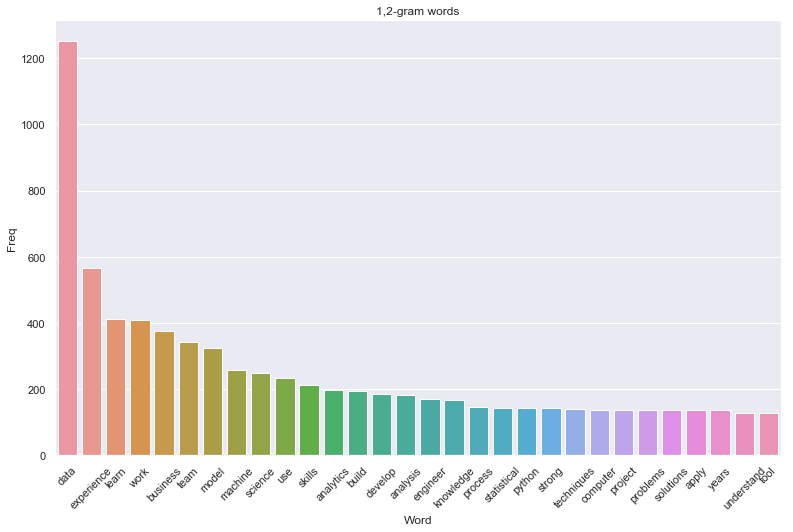

In [79]:
# Visualize
top_words = get_top_n2_words(lemmatized_list, n=30)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_title("1,2-gram words")
g.set_xticklabels(g.get_xticklabels(), rotation=45);